In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
import astropy.units as aus
from astropy.cosmology import z_at_value
import functions_ecc as func
import functions_LISA_ecc as func_LISA
import corner
import multiprocessing as mp
import emcee
from multiprocessing import Pool
from matplotlib import ticker
from scipy import integrate
from scipy.stats import kstest
import gc

GG         = 6.67408e-11
m_earth    = 5.965e24
m_sun      = 1.9891e30
mpc        = 1e6*3.084e16
cc         = 2.998e8
R0         = 1e8 # the radius of TianQin satellites
m_sun_in_s = m_sun*GG/cc**3 # the unit is sec
mpc_in_s   = mpc/cc # the unit is sec
f0         = 1.0/(2*np.pi)*np.sqrt(GG*m_earth/R0**3) # the frequency of TianQin satellites motion
f_star     = 0.28 # the limit of low frequency of TianQin
tt_1yr     = 365*24*3600.0 # 1 year
tto        = 5.0*tt_1yr # 5 years
tto_unit   = tt_1yr/4.0 # 1/4 year, 3 months 
R_1AU      = 1.495978707e11
gamma_E    = 0.577
#difference parameters for FIM
del_zz=0.1
del_ttcr=10**(-3)
del_theta_s_bar=10**(-4)
del_phi_s_bar=10**(-4)
del_incl=10**(-4)
f0_red33=0.01
del_ln_mcr = 1e-8
del_ln_eta = 1e-3    #for TianQin
del_ln_eta = 1e-4    #for LISA
del_zz     = 1e-3     # del_zz = 1e-5
del_ttcr   = 1e-3
del_theta_s_bar = 1e-4
del_phi_s_bar   = 1e-4
del_ln_ee0      = 1e-5

In [409]:
#read sources parameters
redshift = []
mass1r = []
mass2r = []
tc = []
theta_s_bar = []
phi_s_bar = []
theta_l_bar = []
phi_l_bar = []

for line in open("catalogs/catalog22.txt"):
    parameters = line.split()
    redshift.append(float(parameters[0]))
    mass1r.append(float(parameters[1]))
    mass2r.append(float(parameters[2]))
    tc.append(float(parameters[3]))
    theta_s_bar.append(float(parameters[4]))
    phi_s_bar.append(float(parameters[5]))
    theta_l_bar.append(float(parameters[6]))
    phi_l_bar.append(float(parameters[7]))
    
#get e0 using
mu = -2.775
sigma = 0.699
log_e0 = np.random.normal(mu,sigma,len(mass1r))

e0 = []
for i in log_e0:
    e0.append(10**i)
#get delta_e0 using FIM
de_e0_ratio = []
for kk in range(len(mass1r)):
    Sigma_3, Del_Omega_bar, Sigma_0, Sigma_1, Sigma_2, Del_V, Sigma_6, Sigma_7 = func.parameters_estimate_TQ_LISA(mass1r[kk], mass2r[kk], del_ln_mcr, del_ln_eta, redshift[kk], del_zz, tc[kk], del_ttcr, theta_s_bar[kk], del_theta_s_bar, phi_s_bar[kk], del_phi_s_bar, theta_l_bar[kk], phi_l_bar[kk], del_incl, f0_red33, e0[kk], del_ln_ee0)
    de_e0_ratio.append(Sigma_7)
    
de_e0 = []
for i in range(len(de_e0_ratio)):
    de_e0.append(de_e0_ratio[i]*e0[i])

np.savetxt("e0.csv",e0,delimiter=',')
np.savetxt("FIM_e0.csv",de_e0,delimiter=",")

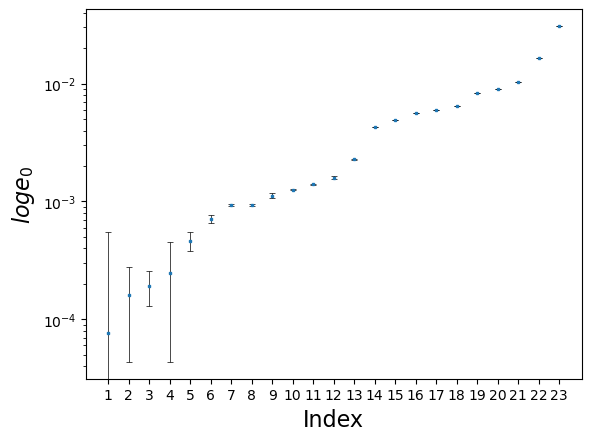

In [410]:
#e0
de_e0 = np.loadtxt('FIM_e0.csv',delimiter=',')
e0 = np.loadtxt('e0.csv',delimiter=',')
de_e0 = de_e0.tolist()
e0 = e0.tolist()

e0_sort = []
de_e0_sort = []
for ii in np.argsort(e0):
    e0_sort.append(e0[ii])
    de_e0_sort.append(de_e0[ii])
'''t = 0
index = []
for ii in range(len(log_e0)):
    if de_log_e0[ii]>10:
        index.append(ii)
        t = t+1
print(t)
index.reverse()
for ii in index:
    de_log_e0.pop(ii)
    log_e0.pop(ii)
  
t = 0
index = []
for ii in range(len(log_e0)):
    if log_e0[ii]>-2 or log_e0[ii]<-3:
        index.append(ii)
        t = t+1
print(t)
index.reverse()
for ii in index:
    de_log_e0.pop(ii)
    log_e0.pop(ii)
'''
x = np.arange(1,len(e0)+1,1).astype(dtype=str)
plt.errorbar(x,e0_sort,yerr=de_e0_sort,marker='s',ms=2,linestyle='none',ecolor='black',elinewidth=0.5,capsize=2,capthick=0.5)
plt.yscale('log')
plt.ylabel('$loge_0$',size=16)
plt.xlabel('Index',size=16)
plt.savefig('errorbar.png')

In [30]:
index = []
for i in range(len(e0)):
    new_e0 = np.random.normal(e0[i],de_e0[i])
    if new_e0<=0:
        index.append(i)
    else:
        e0[i] = new_e0
index.reverse()
for i in index:
    e0.pop(i)
    de_e0.pop(i)
    mass1r.pop(i)
    mass2r.pop(i)
    redshift.pop(i)
    tc.pop(i)
    theta_s_bar.pop(i)
    phi_s_bar.pop(i)
    theta_l_bar.pop(i)
    phi_l_bar.pop(i) 

de_e0_ratio = []            
for kk in range(len(mass1r)):
    Sigma_3, Del_Omega_bar, Sigma_0, Sigma_1, Sigma_2, Del_V, Sigma_6, Sigma_7 = func.parameters_estimate(mass1r[kk], mass2r[kk], del_ln_mcr, del_ln_eta, redshift[kk], del_zz, tc[kk], del_ttcr, theta_s_bar[kk], del_theta_s_bar, phi_s_bar[kk], del_phi_s_bar, theta_l_bar[kk], phi_l_bar[kk], del_incl, f0_red33, e0[kk], del_ln_ee0)
    de_e0_ratio.append(Sigma_7)
    
de_e0 = []
for i in range(len(de_e0_ratio)):
    de_e0.append(de_e0_ratio[i]*e0[i])
    
    
np.savetxt("e0.csv",e0,delimiter=',')
np.savetxt("FIM_e0.csv",de_e0,delimiter=",")

In [2]:
#log_e0
#read sources parameters
redshift = []
mass1r = []
mass2r = []
tc = []
theta_s_bar = []
phi_s_bar = []
theta_l_bar = []
phi_l_bar = []

for line in open("catalogs/catalog22.txt"):
    parameters = line.split()
    redshift.append(float(parameters[0]))
    mass1r.append(float(parameters[1]))
    mass2r.append(float(parameters[2]))
    tc.append(float(parameters[3]))
    theta_s_bar.append(float(parameters[4]))
    phi_s_bar.append(float(parameters[5]))
    theta_l_bar.append(float(parameters[6]))
    phi_l_bar.append(float(parameters[7]))

In [53]:
#log_e0
#read sources parameters
redshift = []
mass1r = []
mass2r = []
tc = []
theta_s_bar = []
phi_s_bar = []
theta_l_bar = []
phi_l_bar = []

for line in open("catalogs/catalog22.txt"):
    parameters = line.split()
    redshift.append(float(parameters[0]))
    mass1r.append(float(parameters[1]))
    mass2r.append(float(parameters[2]))
    tc.append(float(parameters[3]))
    theta_s_bar.append(float(parameters[4]))
    phi_s_bar.append(float(parameters[5]))
    theta_l_bar.append(float(parameters[6]))
    phi_l_bar.append(float(parameters[7]))

#get e0 using
mu = -2.775
sigma = 0.699
log_e0 = np.random.normal(mu,sigma,len(mass1r))
log_e0 = log_e0.tolist()

e0 = []
for i in log_e0:
    e0.append(10**i)

#get delta_e0 using FIM
de_e0_ratio = []
for kk in range(len(mass1r)):
    Sigma_3, Del_Omega_bar, Sigma_0, Sigma_1, Sigma_2, Del_V, Sigma_6, Sigma_7 = func.parameters_estimate(mass1r[kk], mass2r[kk], del_ln_mcr, del_ln_eta, redshift[kk], del_zz, tc[kk], del_ttcr, theta_s_bar[kk], del_theta_s_bar, phi_s_bar[kk], del_phi_s_bar, theta_l_bar[kk], phi_l_bar[kk], del_incl, f0_red33, e0[kk], del_ln_ee0)
    de_e0_ratio.append(Sigma_7)
    
de_log_e0 = []
for i in range(len(de_e0_ratio)):
    de_log_e0.append(de_e0_ratio[i]/np.log(10))


np.savetxt("log_e0.csv",log_e0,delimiter=',')
np.savetxt("FIM_e0.csv",de_log_e0,delimiter=",")

In [86]:
#log_e0
t = 0
index = []
for ii in range(len(log_e0)):
    if log_e0[ii]-2*de_log_e0[ii]<-5:
        index.append(ii)
        t = t+1
print(t)
index.reverse()

list = np.arange(len(log_e0)).tolist()
for i in index:
    list.pop(i)

for i in list:
    while True:
        new_log_e0 = np.random.normal(log_e0[i],de_log_e0[i])
        if -5<=new_log_e0<0:
            log_e0[i] = new_log_e0
            break
            
for i in index:
    while True:
        new_log_e0 = np.random.normal(log_e0[i],de_log_e0[i])
        if -5<=new_log_e0<min(2*log_e0[i]+5,0):
            log_e0[i] = new_log_e0
            break
            
e0 = []
for i in log_e0:
    e0.append(10**i)

#get delta_e0 using FIM
de_e0_ratio = []
for kk in range(len(mass1r)):
    Sigma_3, Del_Omega_bar, Sigma_0, Sigma_1, Sigma_2, Del_V, Sigma_6, Sigma_7 = func.parameters_estimate_TQ_LISA(mass1r[kk], mass2r[kk], del_ln_mcr, del_ln_eta, redshift[kk], del_zz, tc[kk], del_ttcr, theta_s_bar[kk], del_theta_s_bar, phi_s_bar[kk], del_phi_s_bar, theta_l_bar[kk], phi_l_bar[kk], del_incl, f0_red33, e0[kk], del_ln_ee0)
    de_e0_ratio.append(Sigma_7)
    
de_log_e0 = []
for i in range(len(de_e0_ratio)):
    de_log_e0.append(de_e0_ratio[i]/np.log(10))


np.savetxt("log_e0.csv",log_e0,delimiter=',')
np.savetxt("FIM_e0.csv",de_log_e0,delimiter=",")

1


In [15]:
#log_e0
t = 0
index = []
for ii in range(len(log_e0)):
    if de_log_e0[ii]>10:
        index.append(ii)
        t = t+1
print(t)
index.reverse()
for ii in index:
    de_log_e0.pop(ii)
    log_e0.pop(ii)
    mass1r.pop(ii)
    mass2r.pop(ii)
    redshift.pop(ii)
    tc.pop(ii)
    theta_s_bar.pop(ii)
    phi_s_bar.pop(ii)
    theta_l_bar.pop(ii)
    phi_l_bar.pop(ii)
    
np.savetxt("log_e0.csv",log_e0,delimiter=',')
np.savetxt("FIM_e0.csv",de_log_e0,delimiter=",")

0


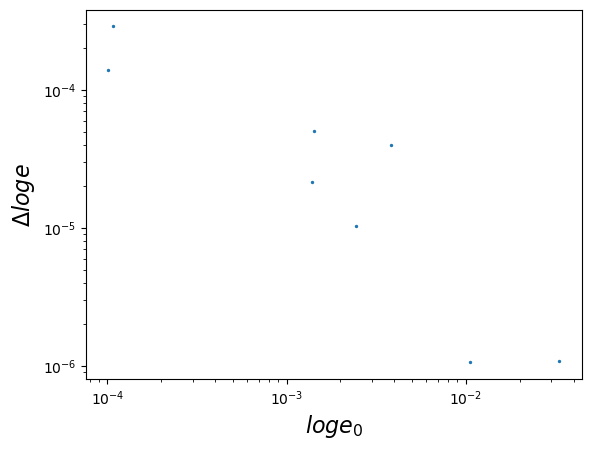

In [4]:
#e0
de_e0 = np.loadtxt('FIM_e0.csv',delimiter=',')
e0 = np.loadtxt('e0.csv',delimiter=',')
de_e0 = de_e0.tolist()
e0 = e0.tolist()

x = np.arange(0,0.02,1e-3)
plt.scatter(e0,de_e0,s=2)
#plt.plot(x,x,linestyle='--',c='grey')
plt.xlabel('$log e_0$',size=16)
plt.ylabel('$\Delta log e$',size=16)
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0,0.0025)
#plt.ylim(0,0.0025)
#axes = plt.gca()
#axes.set_aspect(aspect=1)
plt.savefig('1.png')

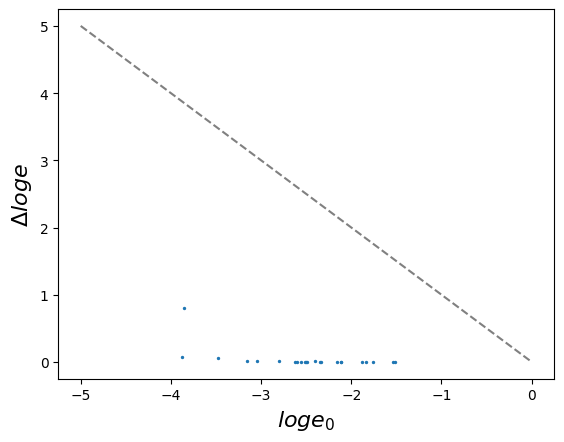

In [87]:
#log_e0
de_log_e0 = np.loadtxt('FIM_e0.csv',delimiter=',')
log_e0 = np.loadtxt('log_e0.csv',delimiter=',')
de_log_e0 = de_log_e0.tolist()
log_e0 = log_e0.tolist()

x = np.arange(-5,0,1e-3)
plt.scatter(log_e0,de_log_e0,s=2)
plt.plot(x,-x,linestyle='--',c='grey')
plt.xlabel('$log e_0$',size=16)
plt.ylabel('$\Delta log e$',size=16)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-8,1)
#plt.ylim(0,20)
#axes = plt.gca()
#axes.set_aspect(aspect=1)
plt.savefig('1.png')

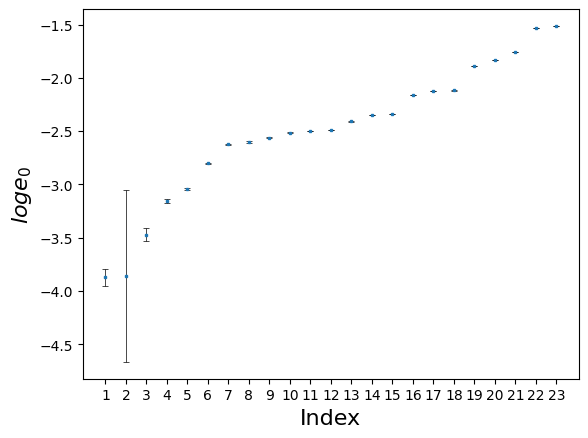

In [88]:
#log_e0
de_log_e0 = np.loadtxt('FIM_e0.csv',delimiter=',')
log_e0 = np.loadtxt('log_e0.csv',delimiter=',')
de_log_e0 = de_log_e0.tolist()
log_e0 = log_e0.tolist()

log_e0_sort = []
de_log_e0_sort = []
for ii in np.argsort(log_e0):
    log_e0_sort.append(log_e0[ii])
    de_log_e0_sort.append(de_log_e0[ii])
'''t = 0
index = []
for ii in range(len(log_e0)):
    if de_log_e0[ii]>10:
        index.append(ii)
        t = t+1
print(t)
index.reverse()
for ii in index:
    de_log_e0.pop(ii)
    log_e0.pop(ii)
  
t = 0
index = []
for ii in range(len(log_e0)):
    if log_e0[ii]>-2 or log_e0[ii]<-3:
        index.append(ii)
        t = t+1
print(t)
index.reverse()
for ii in index:
    de_log_e0.pop(ii)
    log_e0.pop(ii)
'''
x = np.arange(1,len(log_e0)+1,1).astype(dtype=str)
plt.errorbar(x,log_e0_sort,yerr=de_log_e0_sort,marker='s',ms=2,linestyle='none',ecolor='black',elinewidth=0.5,capsize=2,capthick=0.5)
plt.ylabel('$loge_0$',size=16)
plt.xlabel('Index',size=16)
plt.savefig('errorbar.png')

In [121]:
#log_e0
t = 0
for ii in range(len(log_e0)):
    if de_log_e0[ii]>5:
        t = t+1
print(t)

31


In [115]:
#log_e0
t = 0
for ii in range(len(log_e0)):
    if de_log_e0[ii]>=-log_e0[ii]:
        t = t+1
print(t)

34


In [84]:
#log_e0
t = 0
index = []
for ii in range(len(e0)):
    if de_log_e0[ii]>=-log_e0[ii]:
        index.append(ii)
        t = t+1
print(t)
index.reverse()
for ii in index:
    de_log_e0.pop(ii)
    log_e0.pop(ii)

22


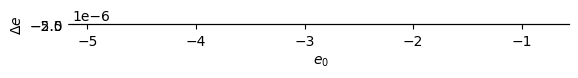

In [10]:
de_e0 = np.loadtxt('FIM_e0.csv',delimiter=',')
e0 = np.loadtxt('log_e0.csv',delimiter=',')
de_e0 = de_e0.tolist()
e0 = e0.tolist()
x = np.arange(1e-8,1,1e-3)
plt.scatter(e0,de_e0,s=2)
plt.plot(x,x,linestyle='--',c='grey')
plt.xlabel('$e_0$')
plt.ylabel('$\Delta e$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-8,1)
plt.ylim(1e-8,1)
axes = plt.gca()
axes.set_aspect(aspect=1)
plt.savefig('1.png')

In [339]:
t = 0
index = []
for ii in range(len(e0)):
    if de_e0[ii]>=e0[ii]:
        index.append(ii)
        t = t+1
print(t)
index.reverse()
for ii in index:
    de_e0.pop(ii)
    e0.pop(ii)

12


In [31]:
t = 0
for ii in range(len(e0)):
    if de_e0[ii]>=e0[ii]:
        t = t+1
print(t)

12


In [98]:
for ii in range(len(e0)):
    if de_e0[ii]>=e0[ii]:
        de_e0[ii] = e0[ii]/10

In [411]:
#e0
for i in range(len(de_e0)):
    a = []
    j = 0
    while j<3000:
        b = np.random.normal(e0[i],de_e0[i])
        if b>0:
            a.append(b)
            j = j+1
    np.savetxt("samples/%s.csv" % str(i),a,delimiter=",")

In [2]:
de_log_e0 = np.loadtxt('FIM_e0.csv',delimiter=',')
log_e0 = np.loadtxt('log_e0.csv',delimiter=',')
de_log_e0 = de_log_e0.tolist()
log_e0 = log_e0.tolist()

In [24]:
#log_e0
for i in range(len(de_log_e0)):
    a = []
    j = 0
    while j<3000:
        b = np.random.normal(log_e0[i],de_log_e0[i])
        if -300<b<0:
            a.append(10**b)
            j = j+1
    np.savetxt("samples/%s.csv" % str(i),a,delimiter=",")

NameError: name 'de_log_e0' is not defined

In [412]:
i = len(de_e0)
j = 3000
samples_mar = np.zeros(shape = ([i,j]),dtype = float)

for ii in range(i):
    a = np.loadtxt("samples/%s.csv" % str(ii),delimiter=",")
    for jj in range(j):
        samples_mar[ii,jj] = a[jj]
        
'''for ii in range(i):
    for jj in range(j):
        if samples_mar[ii,jj]<=0 or samples_mar[ii,jj]>=1:
            print(samples_mar[ii,jj])'''

'for ii in range(i):\n    for jj in range(j):\n        if samples_mar[ii,jj]<=0 or samples_mar[ii,jj]>=1:\n            print(samples_mar[ii,jj])'

<Axes: ylabel='Density'>

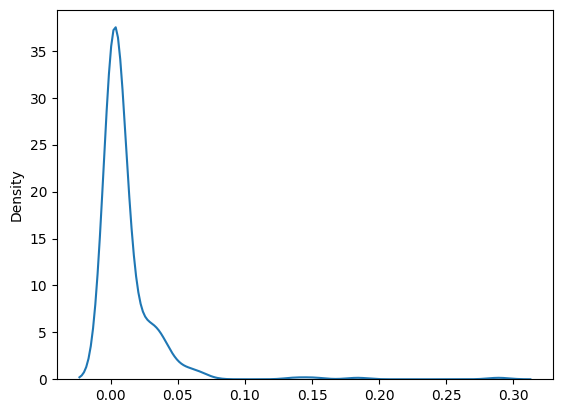

In [41]:
a = []
for ii in range(i):
    a.append(sum(samples_mar[ii,:])/j)
sns.kdeplot(a)

In [5]:
def redshift_prior(x):
    if x<=4.0 and x>=0.0:
        return (cosmo.luminosity_distance(x).value)**2
    else:
        return 1e-300

def m1r_prior(x):
    if x<=100.0 and x>=1.0:
        return 1/99
    else:
        return 1e-100

def m2r_prior(x):
    if x<=100.0 and x>=1.0:
        return 1/99
    else:
        return 1e-100

def tc_prior(x):
    if x<=1e9 and x>=1e7:
        return 1/(1e9-1e7)
    else:
        return 1e-100

def theta_s_prior(x):
    if x<=np.pi and x>=0:
        return 1/np.pi
    else:
        return 1e-100

def phi_s_prior(x):
    if x<=2*np.pi and x>=0:
        return 1/(2*np.pi)
    else:
        return 1e-100


def theta_l_prior(x):
    if x<=np.pi and x>=0:
        return 1/np.pi
    else:
        return 1e-100

def phi_l_prior(x):
    if x<=2*np.pi and x>=0:
        return 1/(2*np.pi)
    else:
        return 1e-100

In [413]:
def ecc_prior(x):
    if x<=1 and x>0:
        return 1
    else:
        return 1e-300

def ecc_model(x,mu,sigma):
    if x<=1 and x>0:
        return (1/(x*np.log(10)*sigma*np.sqrt(2*np.pi)))*np.exp(-(np.log10(x)- mu)**2/(2*sigma**2))
    else:
        return 1e-300
    
def lamda_prior(mu,sigma):
    if mu>-10 and mu<0 and sigma>0 and sigma<5:
        return 1/50
    else:
        return 1e-300

def log_hyper_post(y):
    log_likelihood = []
    if y[1]<=0:
        return -224502
    else:
        for ii in range(i):
            pilamda_pi = []
        
            for jj in range(j):
                pilamda_pi.append(ecc_model(samples_mar[ii,jj],y[0],y[1])/ecc_prior(samples_mar[ii,jj]))
            
            log_likelihood.append(np.log(sum(pilamda_pi)/j))
        return sum(log_likelihood)+np.log(lamda_prior(y[0],y[1]))

In [23]:
%%time
log_hyper_post([-2.69,0.66])

CPU times: user 359 ms, sys: 0 ns, total: 359 ms
Wall time: 359 ms


104.0205928207545

In [3]:
samples = np.zeros(([200,2]),dtype=float)
samples[:,0] = np.linspace(-5,-1,len(samples[:,0]))
samples[:,1] = np.linspace(0.2,2.2,len(samples[:,1]))
posterior = np.zeros(([len(samples[:,0]),len(samples[:,1])]),dtype=float)
def calc_mu_post(x):
    post = []
    for jj in range(len(samples[:,0])):
        post.append(log_hyper_post([samples[x,0],samples[jj,1]]))
    return post

In [415]:
if __name__ == '__main__':
    p = Pool(10)
    P = []
    for ii in range(len(samples[:,0])):
        P.append(p.apply_async(calc_mu_post,args=(ii,)))
    p.close()
    p.join()
    for ii in range(len(samples[:,0])):
        posterior[ii,:] = P[ii].get()
np.savetxt('posterior_TQ_LISA_maximum_Cluster.txt',posterior,delimiter=',')

In [4]:
posterior = np.loadtxt('posterior_TQ_LISA_maximum_Cluster.txt',delimiter=',')

In [7]:
posterior.max()

9.948723227870856

In [6]:
posterior = posterior-1200

In [6]:
for ii in range(len(samples[:,0])):
    for jj in range(len(samples[:,1])):
        posterior[ii,jj] = np.e**(posterior[ii,jj])

n = (samples[1,0]-samples[0,0])*(samples[1,1]-samples[0,1])
area = 0
for ii in range(len(samples[:,0])):
    for jj in range(len(samples[:,1])):
        area = area+n*posterior[ii,jj]
posterior = posterior/area

mu = []
for ii in range(len(samples[:,0])):
    mu.append(sum(posterior[ii,:]*(samples[1,1]-samples[0,1])))
sigma = []
for jj in range(len(samples[:,1])):
    sigma.append(sum(posterior[:,jj]*(samples[1,0]-samples[0,0])))
posterior = posterior.T

In [8]:
credible_interval = [0.954,0.682]
credible_posterior = []

posterior_rank = posterior.reshape(len(samples[:,0])*len(samples[:,1]),1)
posterior_rank = posterior_rank.tolist()
posterior_rank.sort()

n = (samples[1,0]-samples[0,0])*(samples[1,1]-samples[0,1])
for cii in credible_interval:
    area = 0
    for ii in range(len(posterior_rank)):
        area = area+n*posterior_rank[ii][0]
        if area>=1-cii:
            credible_posterior.append(posterior_rank[ii][0])
            print(ii)
            break

38155
39390


In [15]:
np.where(posterior==credible_posterior[0])

(array([80]), array([102]))

In [38]:
#draw PDF
def norm(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/(2*sigma**2))

x_plot = np.linspace(-7,0,1000)
plot_point = np.zeros([1,len(x_plot)],dtype=float)

def calc_plot_point(x):
    point = np.zeros([1,len(x_plot)],dtype=float)
    for jj in range(len(samples[:,1])):
        y = np.fromiter((norm(i,samples[x,0],samples[jj,1]) for i in x_plot),np.float64)
        point = np.r_[point,[y]]
    point = np.delete(point,0,axis=0)
    return point

if __name__ == '__main__':
    p = Pool(8)
    for ii in range(len(samples[:,0])):
        P = p.apply_async(calc_plot_point,args=(ii,))
        plot_point = np.r_[plot_point,P.get()]
    p.close()
    p.join()
plot_point = np.delete(plot_point,0,axis=0)

In [39]:
kk = 0
plot_point_weight = np.zeros([len(samples[:,0])*len(samples[:,1]),len(x_plot)])
for ii in range(len(samples[:,0])):
    for jj in range(len(samples[:,1])):
        plot_point_weight[kk,:] = posterior[jj,ii]*plot_point[kk,:]*n
        kk = kk+1

y_all = []
for ii in range(len(x_plot)):
    y_all.append(sum(plot_point_weight[:,ii]))

In [42]:
kk = 0
plot_point_posterior = np.zeros([len(samples[:,0])*len(samples[:,1]),len(x_plot),2])
for ii in range(len(samples[:,0])):
    for jj in range(len(samples[:,1])):
        for ll in range(len(plot_point[kk,:])):
            plot_point_posterior[kk,ll] = np.array([plot_point[kk,ll],posterior[jj,ii]]) 
        kk = kk+1 

In [66]:
for ii in range(len(plot_point_posterior[0,:,0])):
    index = np.lexsort((plot_point_posterior[:,ii,1],plot_point_posterior[:,ii,0]))
    plot_point_posterior[:,ii,:] = plot_point_posterior[index,ii,:]

In [69]:
y_up = []
y_down = []
for ii in range(len(plot_point_posterior[0,:,0])):
    probability = 0
    indicate = 1
    for jj in range(len(plot_point_posterior[:,0,0])):
        probability = probability+plot_point_posterior[jj,ii,1]*n
        if indicate:
            if probability >=0.05:
                y_down.append(plot_point_posterior[jj,ii,0])
                indicate = 0
        if probability >=0.95:
            y_up.append(plot_point_posterior[jj,ii,0])
            break

In [13]:
for ii in range(len(plot_point[0,:])):
    plot_point[:,ii].sort()
    
y_up_1 = []
y_down_1 = []
for ii in range(len(plot_point[0,:])):
    y_up_1.append(plot_point[int(0.95*len(plot_point[:,0])),ii])
    y_down_1.append(plot_point[int(0.05*len(plot_point[:,0])),ii])

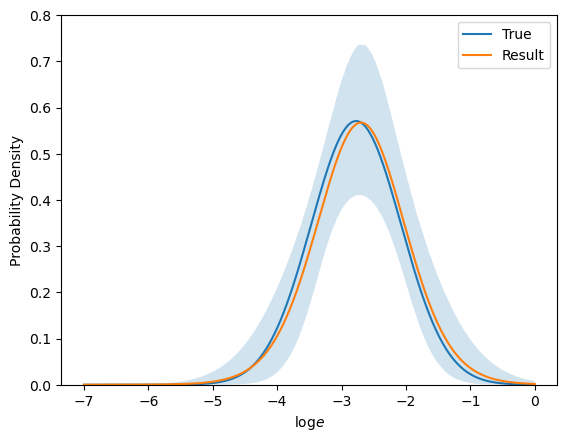

In [77]:
y_test = np.fromiter((norm(i,-2.775,0.699) for i in x_plot),np.float64)

plt.plot(x_plot,y_test,label='True')
plt.plot(x_plot,y_all,label='Result')
#plt.plot(x_plot,y_up,color='grey')
#plt.plot(x_plot,y_down,color='grey')
plt.fill_between(x_plot,y_down,y_up,alpha=0.2)
plt.xlabel('$\mathrm{log}e$')
plt.ylabel('Probability Density')
plt.ylim(0,0.8)
plt.legend()
plt.savefig('PDF.png')

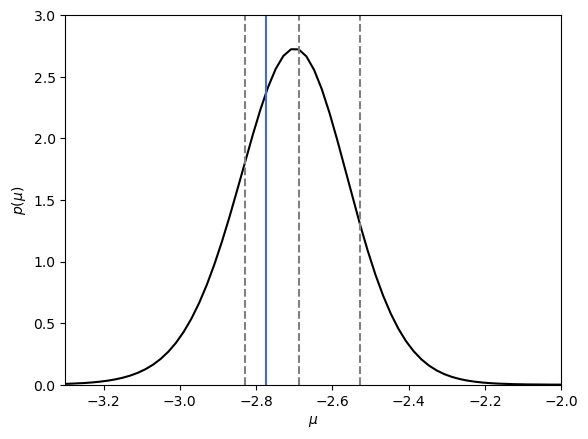

In [78]:
n_mu = samples[1,0]-samples[0,0]
area_mu = 0
for ii in range(len(samples[:,0])):
    area_mu = 0
    for iii in range(ii):
        area_mu = area_mu+n_mu*mu[iii]
    if area_mu>=0.16:
        quan_mu_016 = ii
        break

for ii in range(len(samples[:,0])):
    area_mu = 0
    for iii in range(ii):
        area_mu = area_mu+n_mu*mu[iii]
    if area_mu>=0.5:
        quan_mu_05 = ii
        break
        
for ii in range(len(samples[:,0])):
    area_mu = 0
    for iii in range(ii):
        area_mu = area_mu+n_mu*mu[iii]
    if area_mu>=0.84:
        quan_mu_084 = ii
        break
        
plt.plot(samples[:,0],mu,c='black')
plt.axvline(samples[quan_mu_016,0],linestyle='--',c='grey')
plt.axvline(samples[quan_mu_05,0],linestyle='--',c='grey')
plt.axvline(samples[quan_mu_084,0],linestyle='--',c='grey')
plt.axvline(-2.775,c='royalblue')
plt.xlim(-3.3,-2)
plt.ylim(0,3)
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu)$')
plt.savefig('2.png')

In [423]:
samples[quan_mu_016,0],samples[quan_mu_05,0],samples[quan_mu_084,0]

(-2.829145728643216, -2.688442211055276, -2.527638190954774)

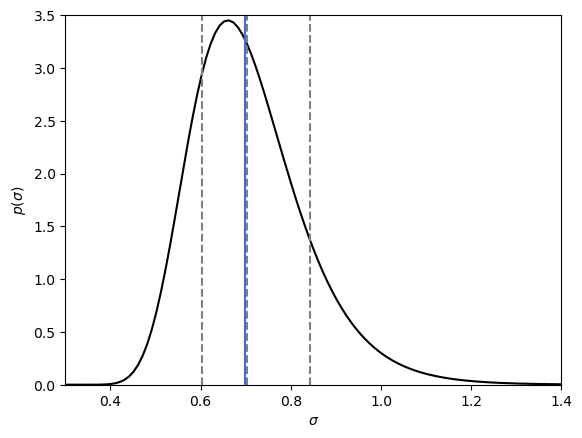

In [79]:
n_sigma = samples[1,1]-samples[0,1]
area_sigma = 0
for jj in range(len(samples[:,0])):
    area_sigma = 0
    for jjj in range(jj):
        area_sigma = area_sigma+n_sigma*sigma[jjj]
    if area_sigma>=0.16:
        quan_sigma_016 = jj
        break
        
for jj in range(len(samples[:,0])):
    area_sigma = 0
    for jjj in range(jj):
        area_sigma = area_sigma+n_sigma*sigma[jjj]
    if area_sigma>=0.5:
        quan_sigma_05 = jj
        break
        
for jj in range(len(samples[:,0])):
    area_sigma = 0
    for jjj in range(jj):
        area_sigma = area_sigma+n_sigma*sigma[jjj]
    if area_sigma>=0.84:
        quan_sigma_084 = jj
        break

plt.plot(samples[:,1],sigma,c='black')
plt.xlim(0.3,1.4)
plt.ylim(0,3.5)
plt.axvline(samples[quan_sigma_016,1],linestyle='--',c='grey')
plt.axvline(samples[quan_sigma_05,1],linestyle='--',c='grey')
plt.axvline(samples[quan_sigma_084,1],linestyle='--',c='grey')
plt.axvline(0.699,c='royalblue')
plt.xlabel('$\sigma$')
plt.ylabel('$p(\sigma)$')
plt.savefig('3.png')

In [425]:
samples[quan_sigma_016,1],samples[quan_sigma_05,1],samples[quan_sigma_084,1]

(0.6020100502512563, 0.7025125628140703, 0.8432160804020101)

In [41]:
area = 0
for ii in range(38277):
    area = area+n*posterior_rank[ii][0]
1-area

0.6821197320423862

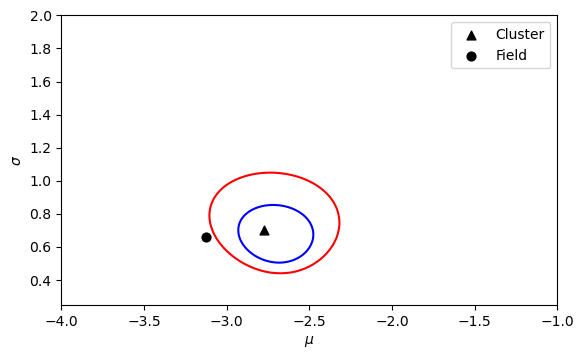

In [9]:
fig,ax = plt.subplots()
levels = np.arange(posterior.min(),posterior.max()+1e-2,1e-2)
#c = plt.contourf(samples[:,0],samples[:,1],posterior,levels,cmap='Blues')
#plt.contour(samples[:,0],samples[:,1],posterior,levels=[0.099*posterior.max()],colors=['grey'])
plt.contour(samples[:,0],samples[:,1],posterior,levels=credible_posterior,colors=['red','blue'])

#plt.axvline(-2.775,c='royalblue',lw=1,label='Cluster')
#plt.axhline(0.699,c='royalblue',lw=1)
plt.scatter(-2.775,0.699,marker='^',c='black',s=40,label='Cluster')

#plt.axvline(-3.124,c='red',lw=1,label='Field')
#plt.axhline(0.658,c='red',lw=1)
plt.scatter(-3.124,0.658,marker='o',c='black',s=40,label='Field')

plt.legend()

#cbar = fig.colorbar(c)
#cbar.ax.set_title('probability density')
#tick_locator = ticker.MaxNLocator(nbins=11)
#cbar.locator = tick_locator
#plt.clabel(c,colors='blue')
ax.set_ylabel('$\sigma$')
ax.set_xlabel('$\mu$')
ax.set_aspect(1)
plt.ylim(0.25,2)
plt.xlim(-4,-1)
#plt.figure(dpi=500)
plt.savefig('4.png')
#c = plt.contour(samples[:,0],samples[:,1],posterior,[1e-1],colors='black',linewidths=0.5)

In [10]:
mu_cluster_index = np.abs(samples[:,0]+2.775)
mu_cluster_index = mu_cluster_index.argmin()

sigma_cluster_index = np.abs(samples[:,1]-0.699)
sigma_cluster_index = sigma_cluster_index.argmin()

mu_field_index = np.abs(samples[:,0]+3.124)
mu_field_index = mu_field_index.argmin()

sigma_field_index = np.abs(samples[:,1]-0.658)
sigma_field_index = sigma_field_index.argmin()

bayes_factor = posterior[sigma_cluster_index,mu_cluster_index]/posterior[sigma_field_index,mu_field_index]
bayes_factor

86.97014328754497

In [39]:
def lognorm(x,mu,sigma):
    return (1/(x*np.log(10)*np.sqrt(2*np.pi)*sigma))*np.exp(-(np.log10(x)-mu)**2/(2*sigma**2))

In [40]:
def lognorm_CDF(x,mu,sigma):
    CDF = integrate.quad(lognorm,0,x,(mu,sigma))
    return CDF[0]

In [41]:
np.where(posterior==posterior.max())

(array([50]), array([132]))

In [42]:
x = np.arange(1e-5,1e-1,1e-5)
y = np.fromiter((lognorm_CDF(i,-2.77,0.69) for i in x),np.float64)

In [43]:
x_max = np.arange(1e-5,1e-1,1e-5)
y_max = np.fromiter((lognorm_CDF(i,samples[132,0],samples[50,1]) for i in x_max),np.float64)

In [44]:
e0 = []
for i in log_e0:
    e0.append(10**i)
e0.sort()
y_ecc = np.linspace(0,1,len(e0))

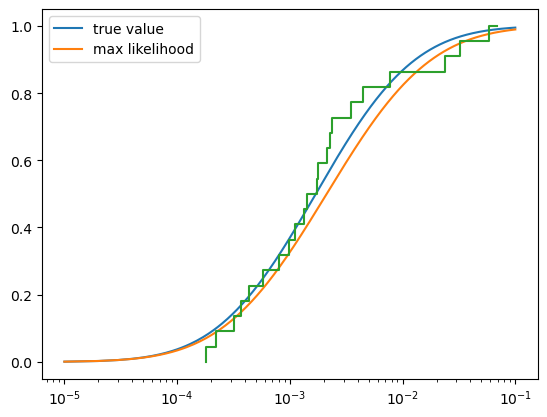

In [45]:
plt.plot(x,y,label='true value')
plt.plot(x_max,y_max,label='max likelihood')
plt.step(e0,y_ecc)
plt.xscale('log')
plt.legend()

In [46]:
kstest(log_e0,'norm',args=(-2.77,0.699))

KstestResult(statistic=0.12366169315963638, pvalue=0.8314923017808306)

In [47]:
kstest(log_e0,'norm',args=(samples[132,0],samples[50,1]))

KstestResult(statistic=0.1718484807036198, pvalue=0.45517823097381527)

In [ ]:
%%time
ndim = 2
nwalker = 4
p0_mu = -10*np.random.rand(nwalker,1)
p0_sigma = 5*np.random.rand(nwalker,1)
p0 = np.zeros((nwalker,ndim),dtype=float)
p0[:,0] = p0_mu[:,0]
p0[:,1] = p0_sigma[:,0]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalker,ndim,log_hyper_post,args=[],pool=pool)
    sampler.run_mcmc(p0,100,progress=True)

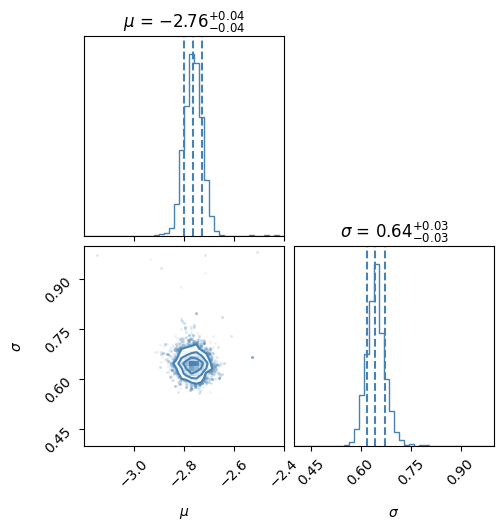

In [12]:
a = np.loadtxt("mu.csv",delimiter=",")
b = np.loadtxt("sigma.csv",delimiter=",")
sample = np.zeros(shape=([len(a),2]),dtype=float)
sample[:,0] = a
sample[:,1] = b
figure = corner.corner(
            sample,
            quantiles=[0.16, 0.5, 0.84],
            labels=[
                r"$\mu$",
                r"$\sigma$",
            ],
            show_titles=True,
            bins=40,
            range=[(-3.2,-2.4),(0.4,1.)],
            color="steelblue")